# Разработка сверточной нейронной сети

## Задание 1. Подготовка данных и окружения

In [105]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score

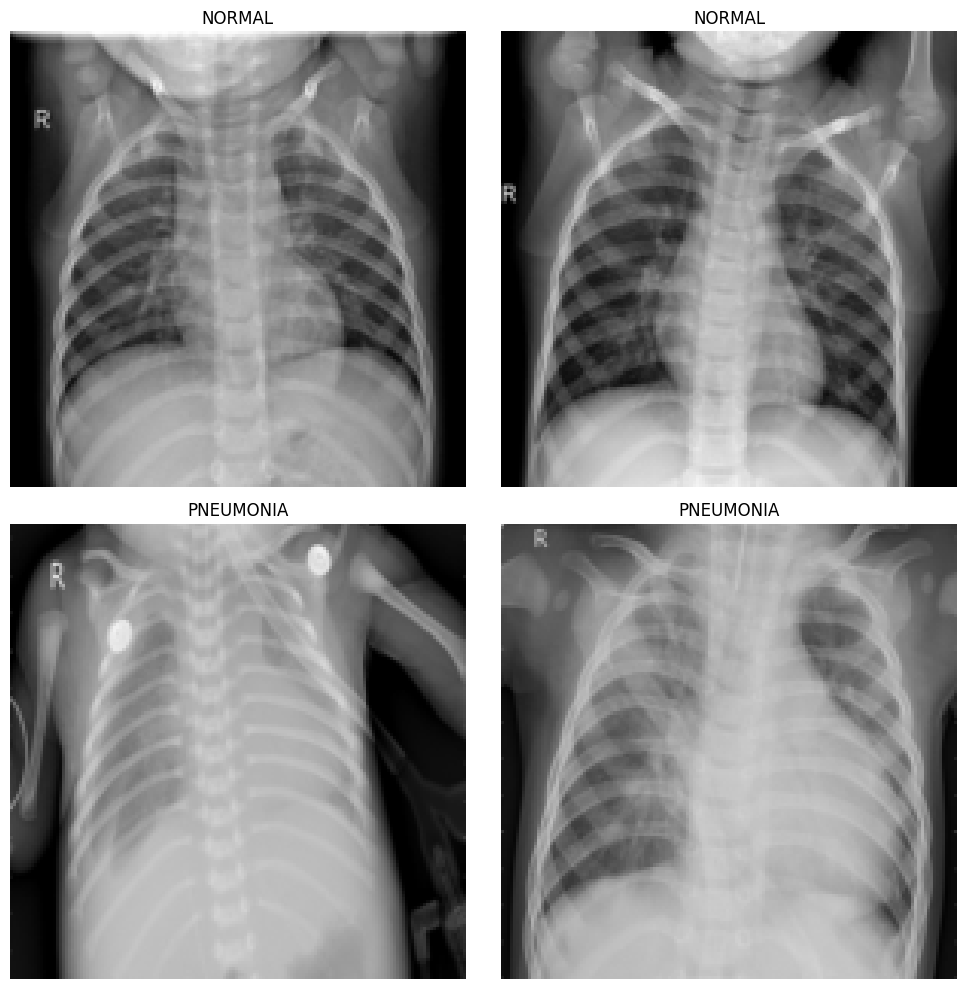

In [104]:
BASE_DIR = '/Users/user_edp/Desktop/projects_21school/chest_xray'

def get_imgs(path):
    full_path = f'{BASE_DIR}/{path}'
    np.random.seed(42)
    
    return [Image.open(f'{full_path}/{i}').convert('RGB') for i in np.random.choice(os.listdir(full_path), 2)]
    

normal_imgs = get_imgs('train/NORMAL/')
pneum_imgs = get_imgs('train/PNEUMONIA/')

transform = transforms.Compose([transforms.Resize((150, 150)), transforms.ToTensor()])

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.ravel()

all_imgs = normal_imgs + pneum_imgs
for i in range(len(all_imgs)):
    img_tensor = transform(all_imgs[i])
    a = img_tensor.permute(1, 2, 0)
    axs[i].imshow(a)
    axs[i].set_title('NORMAL' if i < 2 else 'PNEUMONIA')
    axs[i].axis('off')

plt.tight_layout()
plt.show()

## Задание 2. Создание и обучение нейронной сети

In [106]:
train_dataset = datasets.ImageFolder(f'{BASE_DIR}/train/', transform=transform)
validation_dataset = datasets.ImageFolder(f'{BASE_DIR}/test/', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Сверточные слои
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)

        # Полносвязные слои
        self.fc1 = nn.Linear(128 * 9 * 9, 512)
        self.fc2 = nn.Linear(512, 1)

        # Функции активации
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Применение сверточных слоев и пуллинга
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))

        # В одномерный массив
        x = x.view(-1, 128 * 9 * 9)

        # Полносвязные слои
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))

        return x

model = CNN()
criterion = nn.BCELoss() # функция потерь (бинарная кросс-энтропия)
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels.float().view(-1, 1))

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f'Epoch: [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')


Epoch: [1/20], Loss: 0.3767
Epoch: [2/20], Loss: 0.1324
Epoch: [3/20], Loss: 0.0963
Epoch: [4/20], Loss: 0.0780
Epoch: [5/20], Loss: 0.0676
Epoch: [6/20], Loss: 0.0513
Epoch: [7/20], Loss: 0.0392
Epoch: [8/20], Loss: 0.0563
Epoch: [9/20], Loss: 0.0364
Epoch: [10/20], Loss: 0.0317
Epoch: [11/20], Loss: 0.0222
Epoch: [12/20], Loss: 0.0215
Epoch: [13/20], Loss: 0.0111
Epoch: [14/20], Loss: 0.0256
Epoch: [15/20], Loss: 0.0167
Epoch: [16/20], Loss: 0.0129
Epoch: [17/20], Loss: 0.0140
Epoch: [18/20], Loss: 0.0071
Epoch: [19/20], Loss: 0.0239
Epoch: [20/20], Loss: 0.0182


## Задание 3. Оценка качества модели

In [107]:
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in validation_loader:
        outputs = model(images)
        preds = (outputs > 0.5).float()
        all_labels.extend(labels.numpy())
        all_preds.extend(preds.numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)

print(f'Accuracy: {accuracy :.4f}')
print(f'Precision: {precision :.4f}')
print(f'Recall: {recall:.4f}')

Accuracy: 0.7212
Precision: 0.6929
Recall: 0.9949


Модель обучена достаточно хорошо, но не достигает оптимальной оценки в 80%. 

Пути улучшения модели:
- увеличить количество данных
- аугментация данных
- изменение архитектуры модели
- настройка гиперпараметров
- регуляризация

## Бонусное задание 4. Аугментация данных

In [110]:
augmented_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=(150, 150), scale=(0.8, 1.0)), # зум
    transforms.RandomRotation(degrees=15), # наклон 15 градусов
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform = transforms.Compose([transforms.Resize((150, 150)), transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    

train_dataset_augmented = datasets.ImageFolder(f'{BASE_DIR}/train/', transform=augmented_transform)
train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=32, shuffle=True)

validation_dataset = datasets.ImageFolder(f'{BASE_DIR}/test/', transform=transform)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

model_augmented = CNN()
criterion = nn.BCELoss() # функция потерь (бинарная кросс-энтропия)
optimizer = optim.Adam(model_augmented.parameters(), lr=0.001)

num_epochs = 20
for epoch in range(num_epochs):
    model_augmented.train()
    running_loss = 0.0
    for images, labels in train_loader_augmented:
        optimizer.zero_grad()

        outputs = model_augmented(images)
        loss = criterion(outputs, labels.float().view(-1, 1))

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f'Epoch: [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader_augmented):.4f}')


model_augmented.eval()
all_labels_augmented = []
all_preds_augmented = []

with torch.no_grad():
    for images, labels in validation_loader:
        outputs = model_augmented(images)
        preds = (outputs > 0.5).float()
        all_labels_augmented.extend(labels.numpy())
        all_preds_augmented.extend(preds.numpy())

accuracy = accuracy_score(all_labels_augmented, all_preds_augmented)
precision = precision_score(all_labels_augmented, all_preds_augmented)
recall = recall_score(all_labels_augmented, all_preds_augmented)

print(f'Accuracy: {accuracy :.4f}')
print(f'Precision: {precision :.4f}')
print(f'Recall: {recall:.4f}')


Epoch: [1/20], Loss: 0.3420
Epoch: [2/20], Loss: 0.1640
Epoch: [3/20], Loss: 0.1462
Epoch: [4/20], Loss: 0.1420
Epoch: [5/20], Loss: 0.1341
Epoch: [6/20], Loss: 0.1193
Epoch: [7/20], Loss: 0.1208
Epoch: [8/20], Loss: 0.1095
Epoch: [9/20], Loss: 0.1157
Epoch: [10/20], Loss: 0.1090
Epoch: [11/20], Loss: 0.1028
Epoch: [12/20], Loss: 0.0956
Epoch: [13/20], Loss: 0.1012
Epoch: [14/20], Loss: 0.1017
Epoch: [15/20], Loss: 0.0941
Epoch: [16/20], Loss: 0.0899
Epoch: [17/20], Loss: 0.0936
Epoch: [18/20], Loss: 0.0913
Epoch: [19/20], Loss: 0.0909
Epoch: [20/20], Loss: 0.0825
Accuracy: 0.9054
Precision: 0.9127
Recall: 0.9385


После аугментации точность и качество модели улучшились!